# **Projeto 3 introdução a redes neurais - Autoencoders Variacionais (VAE)**

-------------------------------------------------------------------------------------------------------------

## Objetivo: 

Treinar modelos Variational Autoencoders (VAEs) em dois datasets rotulados, ajustando a topologia com base na função de custo. Explorar o espaço latente com projeção 2D (PCA), avaliando a formação de clusters, separação dos rótulos e variância explicada. Além disso, investigar a possibilidade de enviesar a formação do espaço latente com os rótulos.

## Importando bibliotecas necessárias

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns
# Configuração do Searborn
sns.set(
    style='darkgrid',
    context='notebook',
    rc={
        'axes.spines.top': False,
        'axes.spines.right': False
    }
)

## Primeiro Dataset

O primeiro dataset utilizado é o **MNIST (Modified National Institute of Standards and Technology)**, ele contém 70.000 imagens em escala de cinza, com tamanho de 28x28 pixels, representando dígitos manuscritos de 0 a 9. O dataset é dividido em 60.000 imagens de treinamento e 10.000 de teste,

## Preparação dos dados

#### 1. Normalização das Imagens  
- Os pixels originalmente variam de **0 a 255**.  
- Para melhorar a estabilidade do modelo, os valores são convertidos para **o intervalo [0,1]**, usando divisão por 255.  

#### 2. Separação dos Conjuntos  
- Para avaliar o desempenho do modelo antes do teste, **separamos 5.000 imagens do treino para validação**.  
- Distribuição final dos dados:  
  - **Treino:** 55.000 imagens  
  - **Validação:** 5.000 imagens  
  - **Teste:** 10.000 imagens  

#### 3. Visualização dos Dados  
- São exibidas **10 imagens do conjunto de treino** com seus respectivos rótulos.  
- Isso permite verificar a qualidade e distribuição dos dados antes do treinamento.  

Tamanho do treino: (55000, 28, 28), (55000,)
Tamanho da validação: (5000, 28, 28), (5000,)
Tamanho do teste: (10000, 28, 28), (10000,)


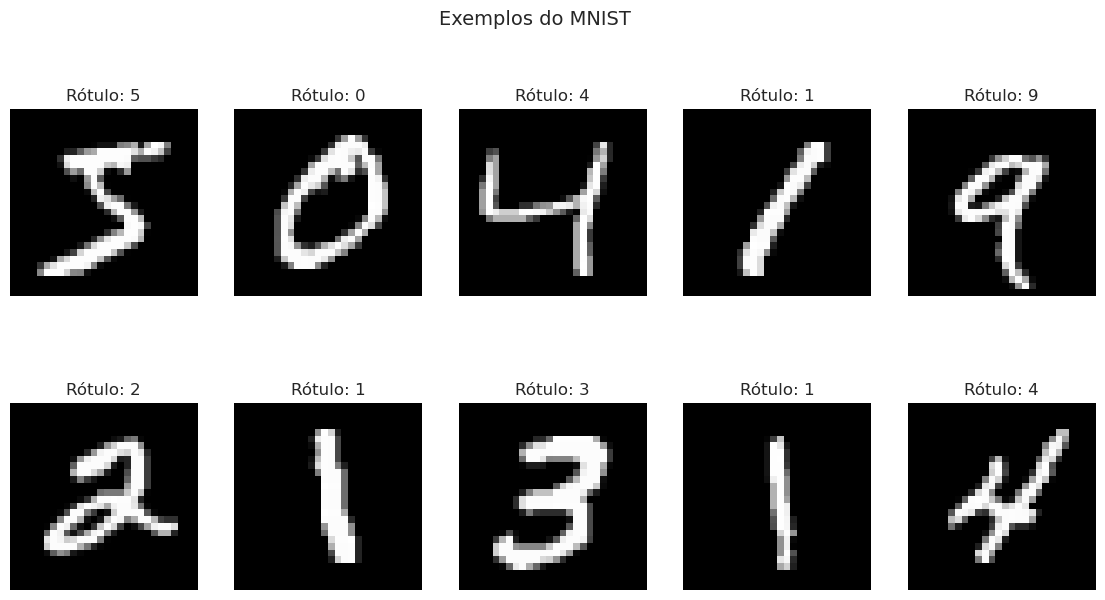

In [2]:
# Carregar o dataset MNIST
(X_treino, y_treino), (X_teste, y_teste) = keras.datasets.mnist.load_data()

# Normalizar os pixels (0-255 → 0-1) e converter para float32
X_treino = X_treino.astype(np.float32) / 255.
X_teste = X_teste.astype(np.float32) / 255.

# Separar treino e validação (55.000 para treino, 5.000 para validação)
X_treino, X_validacao = X_treino[:-5000], X_treino[-5000:]
y_treino, y_validacao = y_treino[:-5000], y_treino[-5000:]

# Exibir os tamanhos dos conjuntos
print(f"Tamanho do treino: {X_treino.shape}, {y_treino.shape}")
print(f"Tamanho da validação: {X_validacao.shape}, {y_validacao.shape}")
print(f"Tamanho do teste: {X_teste.shape}, {y_teste.shape}")

# Plotar exemplos do dataset
plot, i = plt.subplots(2, 5, figsize=(14, 7))
plot.suptitle("Exemplos do MNIST", fontsize=14)

for i, ax in enumerate(i.flat):
    ax.imshow(X_treino[i], cmap="gray")
    ax.set_title(f"Rótulo: {y_treino[i]}")
    ax.axis("off")

## **Autoencoders Variacionais (VAE)**

### Modelos generativos 

Os modelos generativos, como o Variational Autoencoder (VAE), geram novos dados a partir do conhecimento extraído de um conjunto inicial. Ao contrário dos modelos discriminativos, que modelam a probabilidade condicional $P(Y|X)$, os modelos generativos como o VAE modelam a distribuição conjunta $P(X,Y)$, aprendendo a estrutura subjacente dos dados e usandp essa informação para criar novos exemplos semelhantes. 

O VAE impõe uma estrutura probabilística no espaço latente, garantindo que ele siga uma distribuição específica, como uma normal. Isso permite a geração de novos dados realistas a partir da amostragem nesse espaço latente.

Aplicações do VAE incluem geração de imagens, síntese de fala, geração de música, criação de novas moléculas e transferência de estilo, entre outras, ao criar dados sintéticos a partir da distribuição aprendida.


### Autoencoders 

Os autoencoders são redes neurais em sua forma padrão, geralmente compostas por uma rede neural de perceptrons multicamadas (MLP). Eles são divididos em duas partes principais: o codificador (encoder) e o decodificador (decoder). 

Os autoencoders são modelos não supervisionados, ou seja, treinam sem rótulos, com o objetivo de aprender uma representação compacta dos dados. A principal característica é que as saídas do modelo são iguais às entradas, o que os torna também conhecidos como modelos auto-supervisionados.

Durante o treinamento, o codificador mapeia a entrada $x$ para um espaço latente $z$, que é uma representação compacta das características mais importantes dos dados. O decodificador então reconstrói a entrada $x$ a partir dessa representação latente $z$. A função de perda é dada por:


de perda é dada por: $$\text{loss} = | x - d(e(x)) |^2$$

onde $x$ representa a entrada, $e(x)$ é a codificação gerada pelo codificador, e $d(e(x))$ é a reconstrução da entrada pelo decodificador. O objetivo é minimizar essa diferença, fazendo com que a reconstrução se aproxime o máximo possível dos dados originais.

### Autoencoder variacional

O Autoencoder Variacional (VAE) utiliza o espaço latente para gerar novos exemplos. Durante o treinamento, o encoder gera uma distribuição latente $p(z | x)$, e o decoder reconstrói a entrada $x$ a partir de amostras $z$ dessa distribuição. No entanto, se o modelo não for bem treinado, algumas regiões do espaço latente podem gerar exemplos inadequados.

O VAE é regularizado para evitar sobreajuste (overfitting) e garantir que o espaço latente seja contínuo e navegável. Isso permite a geração de novos exemplos de maneira coerente. A principal diferença em relação ao autoencoder padrão é que no VAE o encoder gera uma distribuição latente, e não uma única representação $z$.

A função de custo do VAE combina o erro de reconstrução e a divergência KL entre a distribuição latente e uma distribuição normal padrão $N(0, I)$. A função de perda é dada por:

$$
\text{loss} = \| x - d(e(x)) \|^2 + \text{KL}(N(\mu_x, \sigma_x), N(0, I))
$$

O objetivo é minimizar tanto o erro de reconstrução quanto a divergência KL para garantir um bom espaço latente para a geração de novos dados. 

### Divergência KL e reparametrização 